<h1>Deep Neural Network</h1>

# import

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import torchvision.datasets as ds
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 회귀 문제

## 보스턴 주택 가격 데이터
* dataset 제공 모듈 설치, scikit-learn style

In [3]:
!pip install boston --proxy 70.10.15.10:8080


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from boston import load_boston
seed = 0
torch.manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

boston = load_boston()
X = StandardScaler().fit_transform(boston.data)
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(404, 13) (102, 13) (404,) (102,)


## dataset, dataloader

In [7]:
train_ds = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train).reshape(-1,1))
test_ds = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test.reshape(-1,1)))

train_loader = DataLoader(train_ds, batch_size=100, shuffle=True)
test_loader = DataLoader(test_ds)

## 모델 생성

In [9]:
def boston_housing_model():
  torch.manual_seed(seed)
  model = torch.nn.Sequential(
      torch.nn.Linear(13, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 16),
      torch.nn.ReLU(),
      torch.nn.Linear(16, 1),
  )
  return model.to(device)

## 모델 Summary
* torchinfo : https://github.com/TylerYep/torchinfo

In [5]:
!pip install torchinfo --proxy 70.10.15.10:8080

  Obtaining dependency information for torchinfo from https://files.pythonhosted.org/packages/72/25/973bd6128381951b23cdcd8a9870c6dcfc5606cb864df8eabd82e529f9c1/torchinfo-1.8.0-py3-none-any.whl.metadata



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from torchinfo import summary
model = boston_housing_model()
summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            896
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,160
├─ReLU: 1-4                              --
├─Linear: 1-5                            1,040
├─ReLU: 1-6                              --
├─Linear: 1-7                            17
Total params: 6,113
Trainable params: 6,113
Non-trainable params: 0

## 모델 학습


### 학습, 평가 함수 정의

In [6]:
def fit(model, loader, loss_fn, opt):
  n_batch = len(loader)
  loss=0
  model.train()
  for (x, y) in loader:
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    cost = loss_fn(y_pred, y)
    opt.zero_grad()
    cost.backward()
    opt.step()
    loss += cost.item()/n_batch
  return loss

def evaluate(model, loader, metric_fn):
  loss=0
  n_batch = len(loader)
  model.eval()
  with torch.no_grad():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      y_pred = model(x)
      cost = metric_fn(y_pred, y)
      loss += cost.item()/n_batch
  return loss

In [12]:
model = boston_housing_model()
opt = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

history = {'train_loss':[], 'val_loss':[]}
epochs = 201
for epoch in range(epochs):
  train_loss = fit(model, train_loader, loss_fn, opt)
  history['train_loss'].append(train_loss)

  val_loss = evaluate(model, test_loader, loss_fn)
  history['val_loss'].append(val_loss)
  if epoch%20==0:
    print(f'epoch={epoch}, loss:{train_loss}, val_loss:{val_loss}')

epoch=0, loss:547.9641723632812, val_loss:561.2153505063524
epoch=20, loss:30.018295335769654, val_loss:59.544169668673746
epoch=40, loss:14.034835243225098, val_loss:33.23027146689583
epoch=60, loss:10.01970911026001, val_loss:28.581111859222048
epoch=80, loss:10.6903507232666, val_loss:26.405977716852057
epoch=100, loss:7.506699633598328, val_loss:25.478678781887314
epoch=120, loss:10.577782917022706, val_loss:22.367040464556407
epoch=140, loss:6.471617603302001, val_loss:23.489511249381504
epoch=160, loss:6.678862476348877, val_loss:23.26382251344986
epoch=180, loss:5.524539279937744, val_loss:21.976170080339585
epoch=200, loss:5.742977952957154, val_loss:23.983963164648618


## 학습 곡선 시각화

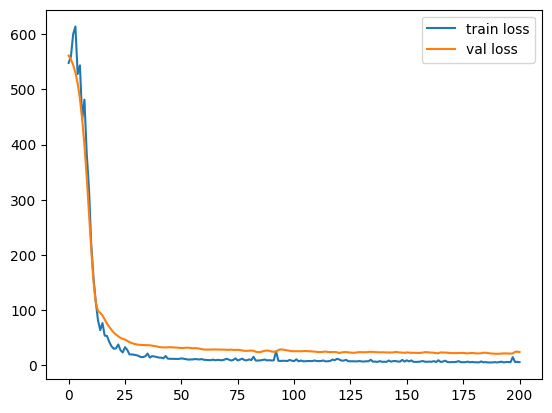

In [13]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend();

## 추론 및 평가

### 추론 함수 정의

In [7]:
def predict(model, loader):
  preds = []
  model.eval()
  with torch.no_grad():
    for X, y in loader:
      X = X.to(device)
      y_pred = model(X)
      preds.append(y_pred.detach().cpu().numpy())
  return np.concatenate(preds)

In [14]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

pred_train = predict(model, DataLoader(train_ds, shuffle=False))
pred_test = predict(model, test_loader)

train_r2 = r2_score(y_train, pred_train)
train_rmse = mean_squared_error(y_train, pred_train, squared=False)
train_mae = mean_absolute_error(y_train, pred_train)

test_r2 = r2_score(y_test, pred_test)
test_rmse = mean_squared_error(y_test, pred_test, squared=False)
test_mae = mean_absolute_error(y_test, pred_test)

print(f'train r2:{train_r2}, rmse:{train_rmse}, mae:{train_mae}')
print(f'test r2:{test_r2}, rmse:{test_rmse}, mae:{test_mae}')


train r2:0.9212234261591612, rmse:2.5898514558311763, mae:1.9319277267644903
test r2:0.7054596258146424, rmse:4.897342433465461, mae:3.1443116346995037


# Batch Size
* Mini-batch
  * 한번의 variable update에 사용할 학습 데이터 묶음
* 2018, Dominic Masters https://arxiv.org/pdf/1804.07612.pdf
* ICLR 2017, Nitish Shirish Keskar https://arxiv.org/pdf/1609.04836.pdf

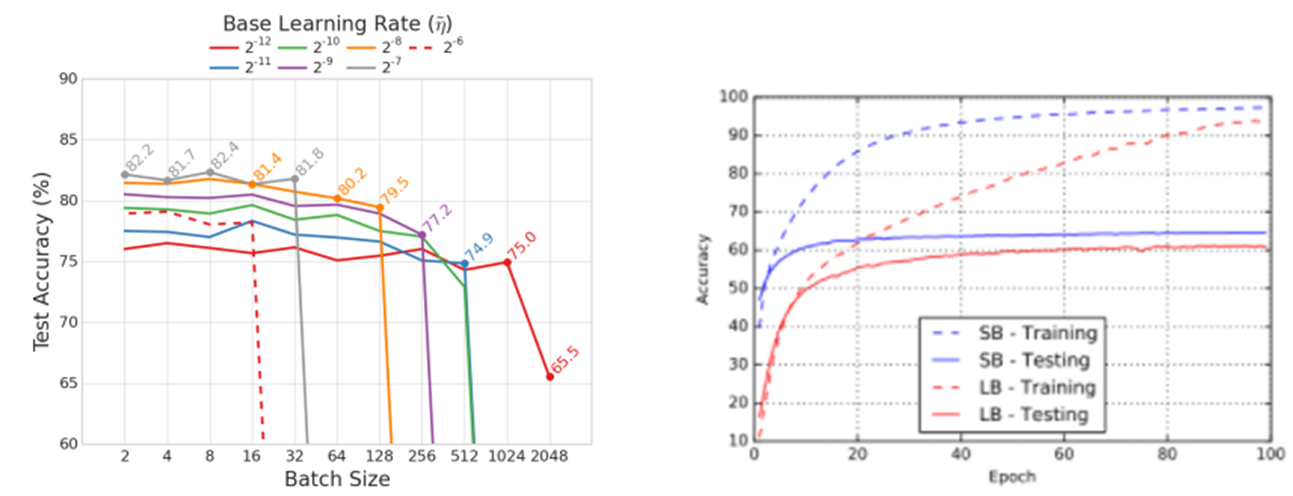

## Small Batch Vs Large Batch
* Small Batch
  * 계산 비용이 작은 연산을 여러 번 실행
  * 비교적 학습이 느리다. 저 성능 Computing power 가능
  * 많은 epoch 필요
  * 좋은 학습 성능
* Large Batch
  * 계산 비용이 큰 연산을 적게 실행
  * 비교적 학습이 빠르다. 고성능 Computing power 요구
  * 일반화(Generalization) 성능 저하(over fitting)

### 최적의 Batch Size 선택하기
* 학습 환경에 실행 가능한 크기
* 성능에 만족할 좋은 가장 큰(빠른) 배치 크기
* 일반적으로 16에서 배수로 크게 또는 작게 설정하면서 최적화
  * ..., 8, 16, 32, ...


## Batch Size 보스턴 주택 가격 실습
* 여러가지 batch size에 따른 성능 비교

In [59]:
b_sizes = [1,2,4,8,16,32,64,128,256]
train_losses = []
val_losses=[]
for i, bsize in enumerate(b_sizes):
  model = boston_housing_model()
  opt = torch.optim.Adam(model.parameters())
  loss_fn = torch.nn.MSELoss()
  train_loader = DataLoader(train_ds, batch_size=bsize)#, shuffle=True)
  test_loader = DataLoader(test_ds)
  for epoch in range(201):
    fit(model, train_loader, loss_fn, opt)
  train_loss = evaluate(model, train_loader, loss_fn)
  val_loss = evaluate(model, test_loader, loss_fn)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print(f'batch_size:{bsize}, train_loss:{train_loss}, val_loss:{val_loss}')

batch_size:1, train_loss:1.8335349324893069, val_loss:17.9509121266761
batch_size:2, train_loss:2.3383956392212655, val_loss:20.652616905377197
batch_size:4, train_loss:2.6963903695935074, val_loss:19.07130079626051
batch_size:8, train_loss:1.6400007903575904, val_loss:16.57294309158198
batch_size:16, train_loss:1.528866501954886, val_loss:17.958853095567157
batch_size:32, train_loss:1.968246918458205, val_loss:17.740735435999884
batch_size:64, train_loss:3.277575169290815, val_loss:18.27407152475402
batch_size:128, train_loss:4.867850244045258, val_loss:20.915377718714343
batch_size:256, train_loss:7.719184398651123, val_loss:22.18867805951923


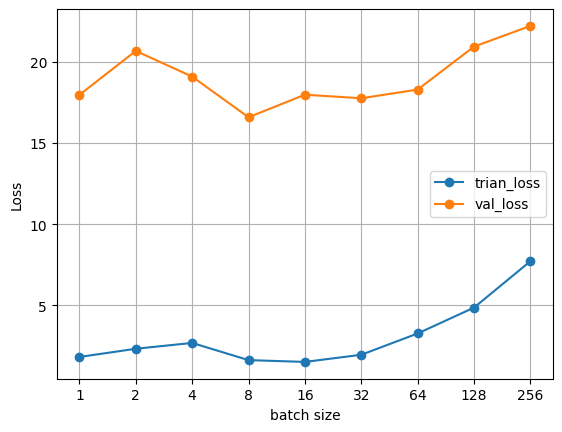

In [60]:
plt.plot(train_losses, label='trian_loss', marker='o')
plt.plot(val_losses, label='val_loss', marker='o')
plt.xticks(range(len(b_sizes)), b_sizes)
plt.legend()
plt.xlabel('batch size');plt.ylabel('Loss')
plt.grid();

# Dropout
* Overfitting 개선
* 학습하는 동안 무작위로 노드를 학습에서 제외
    * 추론 과정에는 완전 연결
* `torch.nn.Dropout(rate)`
  * `rate` = 0.0 ~1.0, 0.5 이하 추천

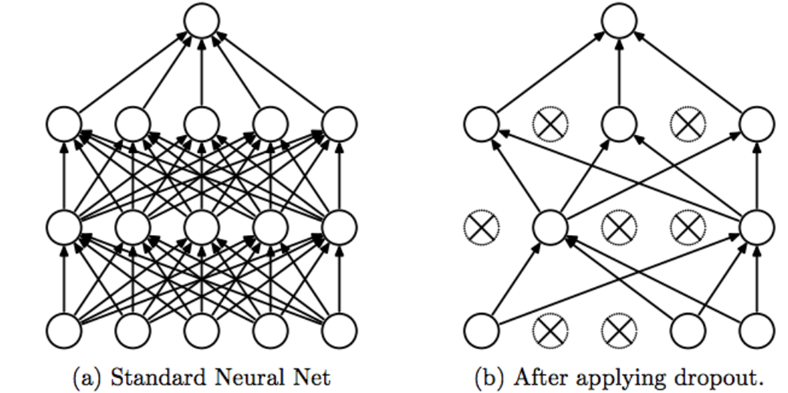


In [31]:
from boston import load_boston
seed = 777
torch.manual_seed(seed)

boston = load_boston()
X = StandardScaler().fit_transform(boston.data)
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

train_ds = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train).reshape(-1,1))
test_ds = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test.reshape(-1,1)))
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds)

torch.manual_seed(seed)
model = torch.nn.Sequential(
    torch.nn.Linear(13, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 1),
).to(device)

opt = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

history = {'train_loss':[], 'val_loss':[]}
epochs = 301
for epoch in range(epochs):
  train_loss = fit(model, train_loader, loss_fn, opt)
  history['train_loss'].append(train_loss)
  val_loss = evaluate(model, test_loader, loss_fn)
  history['val_loss'].append(val_loss)
  if epoch%20==0:
    print(f'epoch={epoch}, loss:{train_loss}, val_loss:{val_loss}')

epoch=0, loss:580.24503326416, val_loss:553.252898809478
epoch=20, loss:35.40286612510682, val_loss:17.947015765240405
epoch=40, loss:30.236700455347698, val_loss:15.759257726789274
epoch=60, loss:25.40456628799439, val_loss:14.4693748327002
epoch=80, loss:26.571079274018604, val_loss:13.731019472074966
epoch=100, loss:20.593767484029136, val_loss:14.262550637215798
epoch=120, loss:19.41460704803467, val_loss:13.561284875055048
epoch=140, loss:15.2316862543424, val_loss:13.169023628308116
epoch=160, loss:15.567306637763975, val_loss:12.982812917746386
epoch=180, loss:14.434285700321198, val_loss:12.769730564716987
epoch=200, loss:15.763218363126118, val_loss:12.812193537992606
epoch=220, loss:16.55132704973221, val_loss:12.69025251871689
epoch=240, loss:14.021391212940218, val_loss:12.26690844329283
epoch=260, loss:13.767617384592693, val_loss:11.46751136541382
epoch=280, loss:15.342362960179644, val_loss:11.754991061413495
epoch=300, loss:12.986681262652077, val_loss:11.63412240057024

## 학습 곡선 시각화

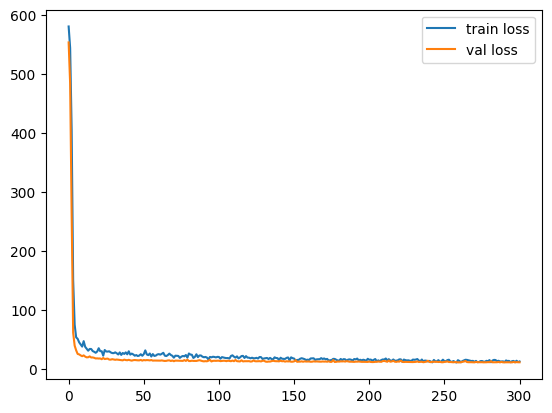

In [32]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend();

## 추론 및 평가

In [33]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

pred_train = predict(model, DataLoader(train_ds, shuffle=False))
pred_test = predict(model, test_loader)

train_r2 = r2_score(y_train, pred_train)
train_rmse = mean_squared_error(y_train, pred_train, squared=False)
train_mae = mean_absolute_error(y_train, pred_train)

test_r2 = r2_score(y_test, pred_test)
test_rmse = mean_squared_error(y_test, pred_test, squared=False)
test_mae = mean_absolute_error(y_test, pred_test)


print(f'train r2:{train_r2}, rmse:{train_rmse}, mae:{train_mae}')
print(f'test r2:{test_r2}, rmse:{test_rmse}, mae:{test_mae}')

train r2:0.9224537670486854, rmse:2.5765725611590993, mae:1.8230430794265464
test r2:0.8560006911997812, rmse:3.4108829142963857, mae:2.4450443748414044


# 이진분류 문제

## 손실함수 : Binary Cross Entropy
* 이진 분류 : 정답이 0과 1만 있는 경우
  * 확률로 해석하면 Positive의 확률만 존재
  * Negative의 확률 계산 필요
* $\displaystyle cost(W) = \sum err(y, \hat{y})$
  * $err(y, \hat{y}) = \begin{cases}     y\cdot-log(\hat{y}) & \quad\text{if } y=1\\     (1-y)\cdot-log(1-\hat{y}) & \quad\text {if } y=0   \end{cases}$
* $ \displaystyle cost(W) = \sum\Big(y \cdot -log(\hat{y}) + (1-y) \cdot -log(1-\hat{y})\Big) $
* $ \displaystyle cost(W) = -\sum\Big(y \cdot log(\hat{y}) + (1-y) \cdot log(1-\hat{y})\Big)$(\hat{y}) + (1-y) \cdot log(1-\hat{y})]$

Text(0.5, 1.0, '$-log(p) + (-log(1-p))$')

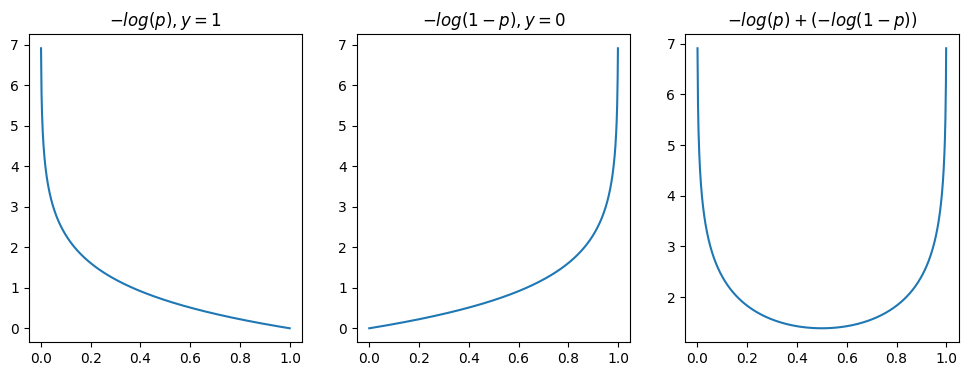

In [ ]:
p = np.arange(0.001, 1, 0.001)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(p, -np.log(p))
plt.title("$-log(p), y=1$")
plt.subplot(1,3,2)
plt.plot(p, -np.log(1-p))
plt.title("$-log(1-p), y=0$")
plt.subplot(1,3,3)
plt.plot(p, -np.log(p) + (-np.log(1-p)))
plt.title('$-log(p) + (-log(1-p))$')

## Breast cancer 데이터
* 위스콘신 유방암 데이터

In [48]:
from sklearn.datasets import load_breast_cancer
sedd= 777
cancer = load_breast_cancer()
X = StandardScaler().fit_transform(cancer.data)
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(426, 30) (143, 30) (426,) (143,)


## Dataset, DataLoader

In [49]:
train_ds = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train).reshape(-1,1))
test_ds = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test.reshape(-1,1)))
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

## 모델 생성

In [50]:
torch.manual_seed(seed)
model = torch.nn.Sequential(
    torch.nn.Linear(30, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 1),
    torch.nn.Sigmoid(),
).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            3,968
├─ReLU: 1-2                              --
├─Linear: 1-3                            8,256
├─ReLU: 1-4                              --
├─Linear: 1-5                            2,080
├─ReLU: 1-6                              --
├─Linear: 1-7                            528
├─ReLU: 1-8                              --
├─Linear: 1-9                            17
├─Sigmoid: 1-10                          --
Total params: 14,849
Trainable params: 14,849
Non-trainable params: 0

## 모델 학습

In [51]:
opt = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()
history = {'train_loss':[], 'val_loss':[]}

for epoch in range(20):
  train_loss = fit(model, train_loader, loss_fn, opt)
  history['train_loss'].append(train_loss)
  test_loss = evaluate(model, test_loader, loss_fn)
  history['val_loss'].append(test_loss)
  print(f'epoch={epoch}, loss:{train_loss}, val_loss:{test_loss}')


epoch=0, loss:0.5683433170671816, val_loss:0.36470435725318057
epoch=1, loss:0.20044476814843995, val_loss:0.12255900932682884
epoch=2, loss:0.06030141765734663, val_loss:0.11350380805217558
epoch=3, loss:0.043391207672862545, val_loss:0.1167809803866678
epoch=4, loss:0.03526414747574124, val_loss:0.1230356304699348
epoch=5, loss:0.026412165467196182, val_loss:0.12512079952284694
epoch=6, loss:0.02549118451403316, val_loss:0.14382625653201508
epoch=7, loss:0.019887161842133433, val_loss:0.13335012887708014
epoch=8, loss:0.016903072911426772, val_loss:0.1497276733732886
epoch=9, loss:0.014633897066771704, val_loss:0.15508297310831648
epoch=10, loss:0.013616941015546523, val_loss:0.1612563303982218
epoch=11, loss:0.011911511881205823, val_loss:0.16553358355950978
epoch=12, loss:0.009705630981544448, val_loss:0.17026523905547541
epoch=13, loss:0.008548388202648817, val_loss:0.18863508216519323
epoch=14, loss:0.007105262840653907, val_loss:0.18793145158431596
epoch=15, loss:0.0051507205671

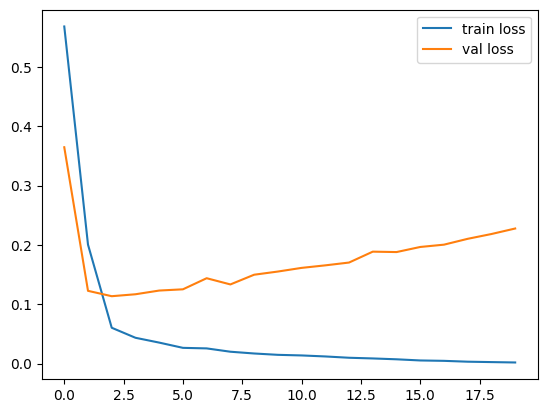

In [52]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend();

In [53]:
from sklearn.metrics import accuracy_score

pred_train = predict(model, DataLoader(train_ds, shuffle=False))
pred_test = predict(model, test_loader)

acc_train = accuracy_score(y_train, pred_train>=0.5)
acc_test = accuracy_score(y_test, pred_test>=0.5)
print(f'train acc:{acc_train}, test acc:{acc_test}')

train acc:1.0, test acc:0.9440559440559441


# Regularization
*  비용 함수에 규제 항 추가
* $minimize(Cost(w) + \alpha||w||)$
* `Optimizer(weight_decay=alpha)`

In [54]:
torch.manual_seed(0)
model = torch.nn.Sequential(
    torch.nn.Linear(30, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 1),
    torch.nn.Sigmoid(),
).to(device)

opt = torch.optim.Adam(model.parameters(), weight_decay=0.02)
loss_fn = torch.nn.BCELoss()

history = {'train_loss':[], 'val_loss':[]}
for epoch in range(20):
  train_loss = fit(model, train_loader, loss_fn, opt)
  history['train_loss'].append(train_loss)
  test_loss = evaluate(model, test_loader, loss_fn)
  history['val_loss'].append(test_loss)
  print(f'epoch={epoch}, loss:{train_loss}, val_loss:{test_loss}')

epoch=0, loss:0.6594414159103675, val_loss:0.5700831214586893
epoch=1, loss:0.43419147531191515, val_loss:0.3033553908268611
epoch=2, loss:0.28374569449159837, val_loss:0.24834758374426102
epoch=3, loss:0.18130543358899925, val_loss:0.15040189276138943
epoch=4, loss:0.08399750947676325, val_loss:0.1123291506535477
epoch=5, loss:0.07053471991309411, val_loss:0.11748331164320308
epoch=6, loss:0.06424486236991706, val_loss:0.11247943507300484
epoch=7, loss:0.06109849639512875, val_loss:0.10352284585436185
epoch=8, loss:0.0590184951821963, val_loss:0.10786214139726426
epoch=9, loss:0.054846112133452196, val_loss:0.10321958300968011
epoch=10, loss:0.05493520103670933, val_loss:0.11330803814861509
epoch=11, loss:0.05574722677745201, val_loss:0.1067083761509922
epoch=12, loss:0.052768691063479145, val_loss:0.10431444272398949
epoch=13, loss:0.04973532159433321, val_loss:0.10542673658993508
epoch=14, loss:0.05358273394543815, val_loss:0.10171142199801074
epoch=15, loss:0.051043220312783015, va

## 학습 곡선

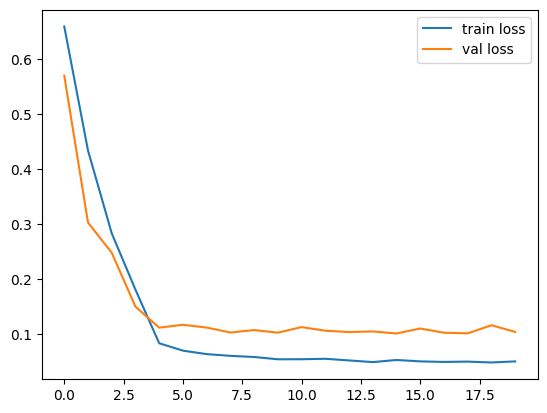

In [55]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend();

## 추론 및 평가

In [56]:
pred_train = predict(model, DataLoader(train_ds, shuffle=False))
pred_test = predict(model, test_loader)

acc_train = accuracy_score(y_train, pred_train>=0.5)
acc_test = accuracy_score(y_test, pred_test>=0.5)
print(f'train acc:{acc_train}, test acc:{acc_test}')

train acc:0.9929577464788732, test acc:0.951048951048951


# 다항 분류

## one-hot encoding

In [39]:
y = torch.tensor([0,1,2,0,1,2])
enc = F.one_hot(y, 3)
print(enc)
print(torch.argmax(enc, dim=1))

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
tensor([0, 1, 2, 0, 1, 2])


## Softmax

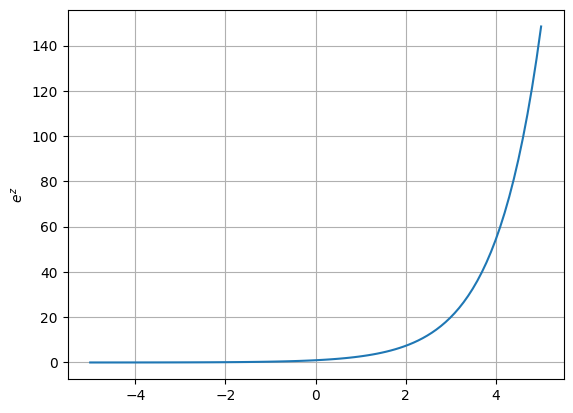

In [40]:
x = np.linspace(-5, 5, 100)
y = np.exp(x)
plt.plot(x, y)
plt.grid()
plt.ylabel('$e^z$');

In [38]:
logits = np.array([[2,3,5]], dtype=np.float32)
print("logits", logits)

p1 = logits/np.sum(logits)
p2 = np.exp(logits)/np.sum(np.exp(logits))
p3 = F.softmax(torch.tensor(logits), dim=1)

print("probability:", p1, "sum:", np.sum(p1))
print("softmax manual:", p2, "sum:", np.sum(p2))
print("softmax torch:", p3, "sum:", torch.sum(p3))

logits [[2. 3. 5.]]
probability: [[0.2 0.3 0.5]] sum: 1.0
softmax manual: [[0.04201006 0.1141952  0.8437947 ]] sum: 1.0
softmax torch: tensor([[0.0420, 0.1142, 0.8438]]) sum: tensor(1.0000)


## MNIST Dataset

In [7]:
import os
os.environ["HTTP_PROXY"] = "70.10.15.10:8080"
os.environ['HTTPS_PROXY'] = "70.10.15.10:8080"
os.environ['CURL_CA_BUNDLE'] = ''
os.environ['PYTHONHTTPSVERIFY'] ='0' 


In [2]:
import torchvision.datasets as ds
import torchvision.transforms as transforms

mnist_train = ds.MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = ds.MNIST('.', train=False, transform=transforms.ToTensor(), download=False)
mnist_train.data.shape, mnist_test.data.shape, mnist_train.data.max(), mnist_train.data.min()

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 9269000.23it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 5078000.16it/s]

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 8162819.16it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 tensor(255, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8))

## Loader, 미리보기

X.shape:torch.Size([32, 1, 28, 28]), X.max():1.0, X.min:0.0
y.shape:torch.Size([32]), y:tensor([8, 6, 9, 3, 0, 4, 6, 2, 9, 9, 9, 1, 8, 2, 8, 2, 7, 8, 8, 2, 3, 7, 3, 7,
        6, 2, 6, 5, 1, 4, 8, 3])


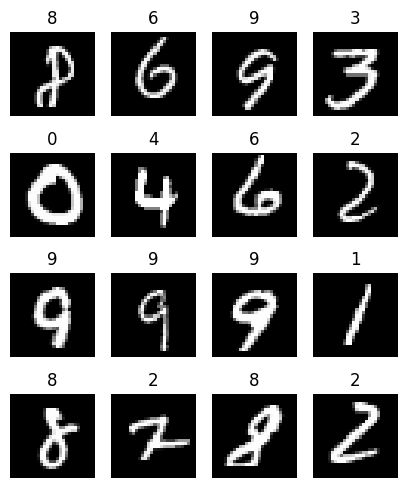

In [5]:
#train_loader = DataLoader(mnist_train, batch_size=16, shuffle=True)
#빠른 실습을 위해 큰 batch 사용
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist_test)

it = iter(train_loader)
X, y = next(it)
print(f'X.shape:{X.shape}, X.max():{X.max()}, X.min:{X.min()}')
print(f'y.shape:{y.shape}, y:{y}')

plt.figure(figsize=(5,6))
for i, (img, label) in enumerate(zip(X, y)):
  plt.subplot(4,4,i+1)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(label.item())
  plt.axis('off')
  if i==15:
    break

## 모델 생성 및 학습

In [8]:
torch.manual_seed(0)
model = torch.nn.Sequential(
  torch.nn.Flatten(),
  torch.nn.Linear(28*28, 64),
  torch.nn.ReLU(),
  torch.nn.Linear(64, 32),
  torch.nn.ReLU(),
  torch.nn.Linear(32, 10),
  #torch.nn.Softmax(dim=1) #CrossEntropyLoss()에 softmax가 포함되어 있기 때문에 제외.
).to(device)
opt = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

history = {'train_loss':[], 'val_loss':[]}
for epoch in range(20):
  train_loss = fit(model, train_loader, loss_fn, opt)
  history['train_loss'].append(train_loss)
  test_loss = evaluate(model, test_loader, loss_fn)
  history['val_loss'].append(test_loss)
  print(f'epoch={epoch}, loss:{train_loss}, val_loss:{test_loss}')

epoch=0, loss:0.34465926102896455, val_loss:0.19964223050010513
epoch=1, loss:0.1579663211433837, val_loss:0.13978562594742486
epoch=2, loss:0.11275515281980243, val_loss:0.10434078566041177
epoch=3, loss:0.08868941872231674, val_loss:0.0955608407172088
epoch=4, loss:0.07304949206467708, val_loss:0.08580069430658048
epoch=5, loss:0.060776807818002994, val_loss:0.0950153231609645
epoch=6, loss:0.05212114985895654, val_loss:0.08974402773474438
epoch=7, loss:0.0457641443208481, val_loss:0.08717865390878854
epoch=8, loss:0.04003028430202977, val_loss:0.08910114172744395
epoch=9, loss:0.03501117929821681, val_loss:0.088359380095837
epoch=10, loss:0.030129315111852104, val_loss:0.10037875471391369
epoch=11, loss:0.027112181134016474, val_loss:0.10050958000654618
epoch=12, loss:0.024822996606451708, val_loss:0.1146107477059818
epoch=13, loss:0.024986921706656447, val_loss:0.1130841620763203
epoch=14, loss:0.02084054808047031, val_loss:0.10826769163879092
epoch=15, loss:0.01823627579139283, va

## 학습 곡선

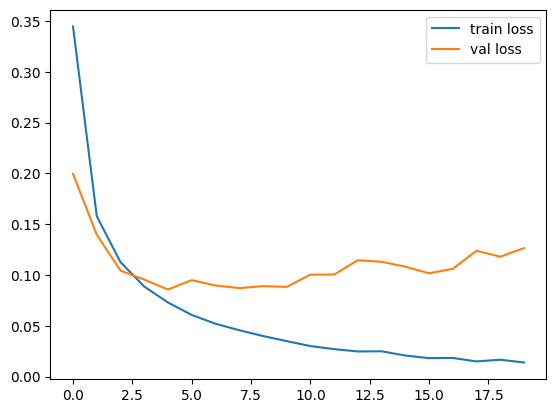

In [9]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend();

## 추론

In [10]:
output = model(mnist_test.data[:5].to(device).float())
print(output)
proba = F.softmax(output, dim=1)
print(proba)
prob, pred = torch.max(proba, dim=1)
print(pred)
torch.argmax(proba, dim=1)

tensor([[ -3771.6721,  -4220.5303,   -731.5916,     94.1089,  -8022.4272,
          -3574.0645, -11034.6465,   4805.4165,  -3317.0549,   -524.8296],
        [ -5926.9717,   1393.1298,   6532.1909,    255.0152, -13652.0410,
          -3830.0012,  -1824.8379,  -4934.6172,  -1878.9954,  -8847.6709],
        [ -3951.2854,   3438.7795,    156.1097,   -662.8342,  -2567.1191,
          -3312.1697,  -1891.8987,    236.1095,   -495.1546,  -3293.5667],
        [  5051.4131,  -4164.3018,   -626.5012,  -1491.4780,  -5417.6494,
          -2134.8958,  -1270.6321,  -1222.4323,  -3156.4075,   -893.6515],
        [ -2963.3098,  -3698.2087,  -3255.7468,  -3986.5833,   3657.5320,
          -2097.1150,  -4534.5029,   -382.1560,  -4513.0396,   1357.2401]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    

tensor([7, 2, 1, 0, 4], device='cuda:0')

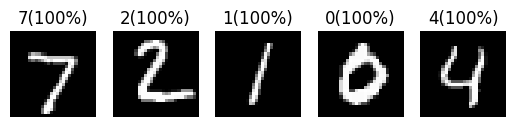

In [11]:
for i, img in enumerate(mnist_test.data[:5]):
  plt.subplot(1, 5, i+1)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title(f'{pred[i].item()}({prob[i].item():.0%})')

## 평가

### 추론 함수 정의


In [12]:
def predict(model, loader, fn=None, **kw):
  preds = []
  model.eval()
  with torch.no_grad():
    for X, y in loader:
      X = X.to(device)
      y_pred = model(X)
      if fn:
        y_pred = fn(y_pred, **kw)
      preds.append(y_pred.detach().cpu().numpy())
  return np.concatenate(preds)

In [13]:
proba_train = predict(model, DataLoader(mnist_train, shuffle=False), F.softmax, dim=1)
proba_test = predict(model, DataLoader(mnist_test, shuffle=False), F.softmax, dim=1)
pred_train = np.argmax(proba_train, axis=1)
pred_test = np.argmax(proba_test, axis=1)
train_acc = accuracy_score(mnist_train.targets.numpy(), pred_train)
test_acc = accuracy_score(mnist_test.targets.numpy(), pred_test)

print(f'train acc:{train_acc}, test acc:{test_acc}')

train acc:0.99585, test acc:0.974


# BatchNormalization

## 모델 생성 및 학습

In [22]:
model = torch.nn.Sequential(
  torch.nn.Flatten(),
  torch.nn.Linear(28*28, 64),
  torch.nn.BatchNorm1d(64),
  torch.nn.ReLU(),
  torch.nn.Linear(64, 32),
  torch.nn.BatchNorm1d(32),
  torch.nn.ReLU(),
  torch.nn.Linear(32, 10),
  #torch.nn.Softmax(dim=1) #CrossEntropyLoss()에 softmax가 포함되어 있어서 제외.
).to(device)
opt = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

history = {'train_loss':[], 'val_loss':[]}
for epoch in range(20):
  train_loss = fit(model, train_loader, loss_fn, opt)
  history['train_loss'].append(train_loss)
  test_loss = evaluate(model, test_loader, loss_fn)
  history['val_loss'].append(test_loss)
  print(f'epoch={epoch}, loss:{train_loss}, val_loss:{test_loss}')

epoch=0, loss:0.3079485821078224, val_loss:0.1170760150644231
epoch=1, loss:0.1298451054284973, val_loss:0.09170645966243075
epoch=2, loss:0.10113565110638725, val_loss:0.08076805411812836
epoch=3, loss:0.08705863253772245, val_loss:0.08113717220314362
epoch=4, loss:0.07492701056227073, val_loss:0.07589732444973091
epoch=5, loss:0.07021273734637848, val_loss:0.07953296476062227
epoch=6, loss:0.06453334872412186, val_loss:0.07923943278387745
epoch=7, loss:0.059894864104812415, val_loss:0.07854035180379824
epoch=8, loss:0.05623261162845096, val_loss:0.07043677672476786
epoch=9, loss:0.05288180295902622, val_loss:0.06992276745069827
epoch=10, loss:0.04940726647245071, val_loss:0.08247887462934533
epoch=11, loss:0.04644964436745896, val_loss:0.06818462642769575
epoch=12, loss:0.04419627010134669, val_loss:0.0781670557311368
epoch=13, loss:0.039656255150865787, val_loss:0.07647050625244142
epoch=14, loss:0.039892627107965116, val_loss:0.08242149910294125
epoch=15, loss:0.03696820133894994, 

## 학습 곡선

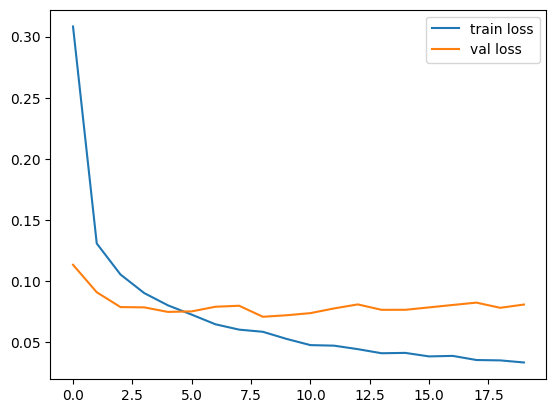

In [15]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend();

## 평가

In [16]:
proba_train = predict(model, DataLoader(mnist_train, shuffle=False), F.softmax, dim=1)
proba_test = predict(model, DataLoader(mnist_test, shuffle=False), F.softmax, dim=1)

pred_train = np.argmax(proba_train, axis=1)
pred_test = np.argmax(proba_test, axis=1)

train_acc = accuracy_score(mnist_train.targets.numpy(), pred_train)
test_acc = accuracy_score(mnist_test.targets.numpy(), pred_test)

print(f'train acc:{train_acc}, test acc:{test_acc}')

train acc:0.9966666666666667, test acc:0.9774


# 모델 배포

## 저장

In [23]:
torch.save(model, './mnist_model')

## 복원

In [24]:
model_re = torch.load('./mnist_model')

out_test = predict(model_re, DataLoader(mnist_test, shuffle=False), F.softmax, dim=1)
pred_test = np.argmax(out_test, axis=1)
test_acc = accuracy_score(mnist_test.targets.numpy(), pred_test)
test_acc

0.9795

## 복원한 모델로 직접 쓴 손글씨 인식하기

*  손 글씨 숫자 쓰기
  * 그림판 또는 온라인 그림판(https://sketch.io/sketchpad/)
  * 미리 써놓은 샘플 숫자 이미지 다운로드 :  0458.png

In [1]:
import os
os.environ["HTTP_PROXY"] = "70.10.15.10:8080"
os.environ['HTTPS_PROXY'] = "70.10.15.10:8080"
os.environ['CURL_CA_BUNDLE'] = ''
os.environ['PYTHONHTTPSVERIFY'] ='0' 


In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
# 강사가 파일을 제공한 경우 실행하지 마세요.
from urllib import request

url = 'https://raw.githubusercontent.com/dltpdn/img2data/master/0458.png'
with request.urlopen(url) as r:
    with open('number.png', 'wb') as f:
      f.write(r.read())

##  img2data 모듈 download

In [19]:
!pip install img2data

## 추론

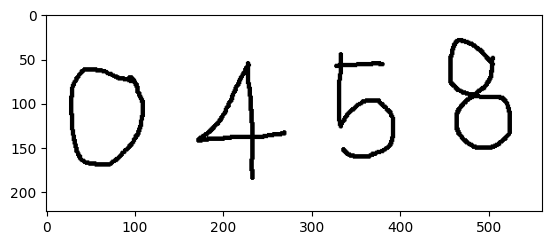

[9.9993801e-01 1.7544285e-06 4.6256879e-05 1.8986328e-06 8.7208463e-09
 8.6512074e-07 7.4644850e-06 1.0206531e-06 2.5118209e-06 1.6867499e-07] 0
[2.8349203e-05 3.1616949e-02 7.5261653e-03 6.3467660e-04 9.5713896e-01
 9.2486449e-04 6.0916017e-07 6.3782639e-04 2.2088365e-05 1.4694972e-03] 4
[1.4664833e-03 1.0021332e-05 3.9290555e-04 2.4771927e-02 5.9632735e-06
 9.6045148e-01 5.5296492e-04 5.8098142e-03 6.0058306e-03 5.3260237e-04] 5
[1.0470693e-05 4.4703643e-06 3.2280454e-06 4.8440503e-04 4.0240531e-05
 1.7038548e-02 1.2902778e-05 2.2873098e-06 9.8183560e-01 5.6785357e-04] 8


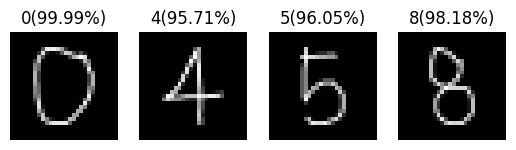

In [45]:
import img2data
import cv2

img_path = 'number.png'
image = cv2.imread(img_path)
plt.imshow(image)
plt.show()

images = img2data.img2digits(image, (28,28), border=4)
for i, img in enumerate(images):
    output = model_re(torch.FloatTensor(img/255.0).to(device))
    proba = F.softmax(output, dim=1).cpu().detach().numpy().squeeze()
    pred = np.argmax(proba)
    print(proba, pred)
    plt.subplot(1, len(images), i+1)
    plt.title(f'{pred}({proba[pred]:.2%})')
    plt.imshow(img.reshape(28,28), cmap="gray")
    plt.axis('off');

# 다중 출력 사용자 정의 모델
* 하나의 입력으로 하나 이상의 출력
* Functional API를 이용한 복잡한 형태의 모델 구성

## 데이터 준비
* 입력 : MNIST 이미지
* 출력 1 : 숫자 분류(다항 분류)
* 출력 2 : 홀수(0) , 짝수(1) 분류(이진 분류)

In [109]:
def collate_fn(batch):
  imgs = []
  y_classes = []
  y_bins = []
  for img, y_class in batch:
    imgs.append(img)
    y_classes.append(y_class)
    y_bins.append(y_class%2) #0:짝수, 1:홀수
  return torch.stack(imgs), torch.tensor(y_classes), torch.FloatTensor(y_bins).reshape(-1,1)

train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(mnist_test, shuffle=False, collate_fn=collate_fn)

for batch in train_loader:
  img = batch[0]
  y_class = batch[1]
  y_bin = batch[2]
  print(img.shape)#, y_class.shape, y_odd.shape)
  print(y_class, y_bin)
  break

torch.Size([32, 1, 28, 28])
tensor([6, 8, 8, 7, 8, 0, 0, 5, 6, 0, 0, 3, 5, 8, 1, 6, 2, 4, 1, 4, 9, 4, 3, 4,
        1, 4, 8, 7, 6, 3, 1, 8]) tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])


## 커스텀 모델 정의

In [114]:
torch.manual_seed(0)
class CustomModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(28*28, 64)
    self.fc2 = torch.nn.Linear(64, 32)
    self.fc_class = torch.nn.Linear(32, 10)
    self.fc_bin = torch.nn.Linear(32, 1)

  def forward(self, X):
    x = self.flatten(X)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    out_class = self.fc_class(x)
    out_bin = self.fc_bin(x)

    return out_class, F.sigmoid(out_bin)

## 커스텀 손실함수 정의

In [ ]:
class CustomLoss():
  def __init__(self):
    self.class_loss_fn = torch.nn.CrossEntropyLoss()
    self.bin_loss_fn = torch.nn.BCELoss()

  def __call__(self, pred_class, pred_odd, true_class, true_odd):
    class_cost = self.class_loss_fn(pred_class, true_class)
    bin_cost = self.bin_loss_fn(pred_odd, true_odd)
    return class_cost + bin_cost

## 모델 학습

In [115]:
def fit(model, loader, loss_fn, opt):
  n_batch = len(loader)
  loss=0
  model.train()
  for (x, y_class, y_bin) in loader:
    x, y_class, y_bin = x.to(device), y_class.to(device), y_bin.to(device)
    y_class_pred, y_bin_pred = model(x)
    cost = loss_fn(y_class_pred, y_bin_pred, y_class, y_bin)
    opt.zero_grad()
    cost.backward()
    opt.step()
    loss += cost.item()/n_batch
  return loss

def evaluate(model, loader, metric_fn):
  loss=0
  n_batch = len(loader)
  model.eval()
  with torch.no_grad():
    for x, y_class, y_bin in loader:
      x, y_class, y_bin = x.to(device), y_class.to(device), y_bin.to(device)
      y_class_pred, y_bin_pred = model(x)
      cost = metric_fn(y_class_pred, y_bin_pred, y_class, y_bin)
      loss += cost.item()/n_batch
  return loss

In [116]:
model = CustomModel().to(device)
opt = torch.optim.Adam(model.parameters())
loss_fn = CustomLoss()
history = {'train_loss':[], 'val_loss':[]}

for epoch in range(20):
  train_loss = fit(model, train_loader, loss_fn, opt)
  history['train_loss'].append(train_loss)
  test_loss = evaluate(model, test_loader, loss_fn)
  history['val_loss'].append(test_loss)
  print(f'epoch={epoch}, loss:{train_loss}, val_loss:{test_loss}')

epoch=0, loss:0.5141109271109103, val_loss:0.26830153235078413
epoch=1, loss:0.24213403507421402, val_loss:0.18812301106852597
epoch=2, loss:0.1808378063187004, val_loss:0.17609745745647112
epoch=3, loss:0.14309601344329587, val_loss:0.19337948541924124
epoch=4, loss:0.11835202195979659, val_loss:0.13180016868901492
epoch=5, loss:0.09969590713152053, val_loss:0.15622908989025772
epoch=6, loss:0.08748066232080254, val_loss:0.1527887914552477
epoch=7, loss:0.07695202524450921, val_loss:0.13545233608701227
epoch=8, loss:0.06609840955265495, val_loss:0.1417914665234314
epoch=9, loss:0.057087989137771945, val_loss:0.1572131126643846
epoch=10, loss:0.05160361444264024, val_loss:0.15671870339975819
epoch=11, loss:0.044982797026176344, val_loss:0.14614096031470572
epoch=12, loss:0.03988804131878231, val_loss:0.16170765389974237
epoch=13, loss:0.03650273647429428, val_loss:0.14867056297454315
epoch=14, loss:0.033797131655506844, val_loss:0.15761842939962104
epoch=15, loss:0.02992257141907853, v

## 추론 및 평가

In [117]:
def predict(model, loader, fn=None, **kw):
  preds_class = []
  preds_bin = []
  model.eval()
  with torch.no_grad():
    for X, y_class, y_bin in loader:
      X = X.to(device)
      y_class_pred, y_bin_pred = model(X)
      if fn:
        y_class_pred = fn(y_class_pred, **kw)
      preds_class.append(y_class_pred.detach().cpu().numpy())
      preds_bin.append(y_bin_pred.detach().cpu().numpy())
  return np.concatenate(preds_class), np.concatenate(preds_bin)

In [118]:
proba_class_train, proba_bin_train = predict(model,
          DataLoader(mnist_train, shuffle=False, collate_fn=collate_fn), F.softmax, dim=1)
proba_class_test, proba_bin_test = predict(model,
          DataLoader(mnist_test, shuffle=False, collate_fn=collate_fn), F.softmax, dim=1)

pred_class_train = np.argmax(proba_class_train, axis=1)
pred_class_test = np.argmax(proba_class_test, axis=1)

pred_bin_train = proba_bin_train >= 0.5
pred_bin_test = proba_bin_test >= 0.5

train_class_acc = accuracy_score(mnist_train.targets.numpy(), pred_class_train)
test_class_acc = accuracy_score(mnist_test.targets.numpy(), pred_class_test)

train_bin_acc = accuracy_score(mnist_train.targets.numpy()%2, pred_bin_train)
test_bin_acc = accuracy_score(mnist_test.targets.numpy()%2, pred_bin_test)

print(f'train class acc:{train_class_acc}, test class acc:{test_class_acc}')
print(f'train bin acc:{train_bin_acc}, test bin acc:{test_bin_acc}')

train class acc:0.9946333333333334, test class acc:0.9732
train bin acc:0.9977, test bin acc:0.9874
